In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
#Handicap was described as a binary categorical variable, so I transformed the non-zero values into 1 
train['Handcap']= np.where(train['Handcap']>0, 1, 0)
test['Handcap']= np.where(test['Handcap']>0, 1, 0)
train['PatientId'] = train['PatientId'].astype('int64')
test['PatientId'] = test['PatientId'].astype('int64')  

In [4]:
test.head()

,No-show,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
0,No,474353326277,5596322,F,2016-04-18T14:23:10Z,2016-05-20T00:00:00Z,36,ILHA DE SANTA MARIA,0,0,0,0,0,0
1,No,239584199629498,5720937,F,2016-05-19T14:55:46Z,2016-05-20T00:00:00Z,15,JABOUR,0,0,0,0,0,0
2,No,452116852376437,5771933,M,2016-06-03T14:09:56Z,2016-06-03T00:00:00Z,17,SANTA HELENA,0,0,0,0,0,0
3,No,91485643691841,5672004,F,2016-05-09T07:30:50Z,2016-05-10T00:00:00Z,20,DA PENHA,0,0,0,0,0,0
4,No,8759582319893,5732657,F,2016-05-24T12:10:04Z,2016-05-25T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,0


In [5]:
#skipped AppointmentID as I'm going to drop it anyway, only filling test as I know train won't have missing values
for_median=['Age']
for_mode=['ScheduledDay','AppointmentDay','PatientId','Gender','Neighbourhood','Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received']
if test.isnull().values.any():
    for me in for_median:
        median = test[me].median()
        test[me].fillna(median, inplace=True)
    for mo in for_mode:
        mode = test[mo].mode()[0]
        test[mo].fillna(mode, inplace= True)
        

   
    

In [6]:
test.isnull().values.sum()

0

In [7]:
#train, target split - dropping 'AppointmentID' because it has a unique value for each sample, therefore making it irrelevant
X_train=train.drop(['No-show','AppointmentID'],axis=1)
y_train=train['No-show']
X_test=test.drop(['No-show','AppointmentID'],axis=1)
y_test=test['No-show']

test.head()

,No-show,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
0,No,474353326277,5596322,F,2016-04-18T14:23:10Z,2016-05-20T00:00:00Z,36,ILHA DE SANTA MARIA,0,0,0,0,0,0
1,No,239584199629498,5720937,F,2016-05-19T14:55:46Z,2016-05-20T00:00:00Z,15,JABOUR,0,0,0,0,0,0
2,No,452116852376437,5771933,M,2016-06-03T14:09:56Z,2016-06-03T00:00:00Z,17,SANTA HELENA,0,0,0,0,0,0
3,No,91485643691841,5672004,F,2016-05-09T07:30:50Z,2016-05-10T00:00:00Z,20,DA PENHA,0,0,0,0,0,0
4,No,8759582319893,5732657,F,2016-05-24T12:10:04Z,2016-05-25T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,0


No     56313
Yes    14423
Name: No-show, dtype: int64


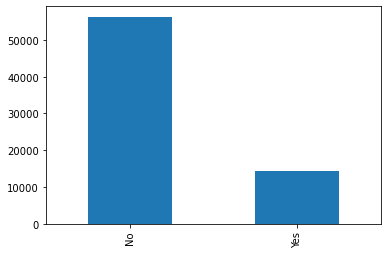

In [8]:
#Target distribution 
print(train['No-show'].value_counts())
p=train['No-show'].value_counts().plot(kind="bar")

Feature Analysis

True     34312
False    12212
dtype: int64


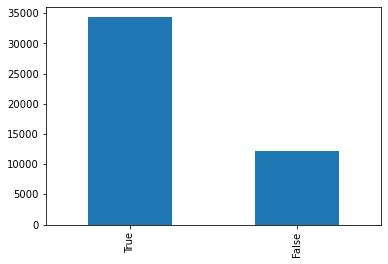

In [9]:
#I noticed that most patients don't show up consistently at their appointments, so I will keep this feature.
train_p_ratio = train[train['No-show'] == 'No'].groupby(['PatientId']).size()/train.groupby(['PatientId']).size()
x=train_p_ratio.map(lambda r: r==1)
print(x.value_counts())
p=x.value_counts().plot(kind="bar")

F    46007
M    24729
Name: Gender, dtype: int64
Gender
F    0.794031
M    0.799951
dtype: float64


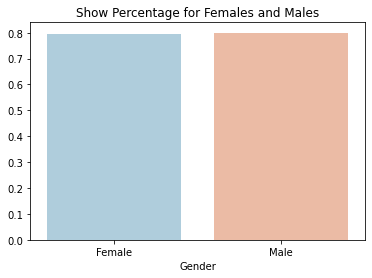

In [10]:
#Percentages of Show between females and males is almost identical, therefore i will drop this feature
train_g_ratio= train[train['No-show'] == 'No'].groupby(['Gender']).size()/train.groupby(['Gender']).size()
p = sns.barplot(x=train_g_ratio.index, y=train_g_ratio, palette="RdBu_r")
p.set_title("Show Percentage for Females and Males")
x_labels=['Female', 'Male']
p.set_xticklabels(x_labels)
print (train.Gender.value_counts())
print (train_g_ratio)
plt.show()

0    68545
1     2191
Name: Alcoholism, dtype: int64
Alcoholism
0    0.795842
1    0.804199
dtype: float64


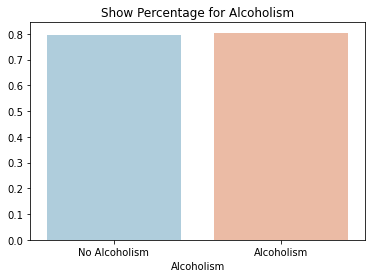

In [11]:
#Percentages of Show between alcoholics and non-alcoholics is almost identical, therefore i will drop this feature
train_a_ratio = train[train['No-show'] == 'No'].groupby(['Alcoholism']).size()/train.groupby(['Alcoholism']).size()
ax = sns.barplot(x=train_a_ratio.index, y=train_a_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Alcoholism")
x_ticks_labels=['No Alcoholism', 'Alcoholism']
ax.set_xticklabels(x_ticks_labels)
print (train.Alcoholism.value_counts())
print (train_a_ratio)
plt.show()

0    47954
1    22782
Name: SMS_received, dtype: int64
SMS_received
0    0.832256
1    0.719998
dtype: float64


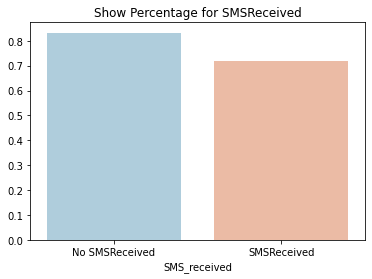

In [12]:
#Percentanges of Show between people who have received sms' and people who have not received any is considerably different, therefore I will keep this feature
train_sms_ratio = train[train['No-show'] == 'No'].groupby(['SMS_received']).size()/train.groupby(['SMS_received']).size()
ax = sns.barplot(x=train_sms_ratio.index, y=train_sms_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for SMSReceived")
x_ticks_labels=['No SMSReceived', 'SMSReceived']
ax.set_xticklabels(x_ticks_labels)
print (train['SMS_received'].value_counts())
print (train_sms_ratio)
plt.show()

0    63740
1     6996
Name: Scholarship, dtype: int64
Scholarship
0    0.800345
1    0.757433
dtype: float64


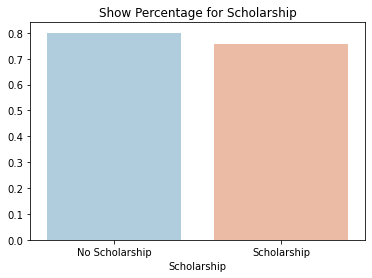

In [13]:
#Percentanges of Show between people who have a scholarship and people who don't is considerably different, therefore I will keep this feature
train_sc_ratio = train[train['No-show'] == 'No'].groupby(['Scholarship']).size()/train.groupby(['Scholarship']).size()
ax = sns.barplot(x=train_sc_ratio.index, y=train_sc_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Scholarship")
x_ticks_labels=['No Scholarship', 'Scholarship']
ax.set_xticklabels(x_ticks_labels)
print (train['Scholarship'].value_counts())
print (train_sc_ratio)
plt.show()

0    65590
1     5146
Name: Diabetes, dtype: int64
Diabetes
0    0.794069
1    0.821998
dtype: float64


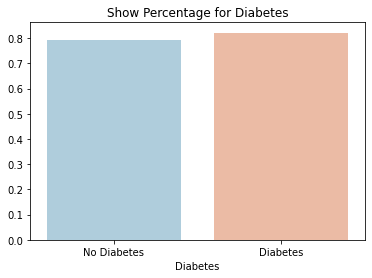

In [14]:
#Percentanges of Show between people who have diabetes and people who don't is considerably different, therefore I will keep this feature
train_d_ratio = train[train['No-show'] == 'No'].groupby(['Diabetes']).size()/train.groupby(['Diabetes']).size()
ax = sns.barplot(x=train_d_ratio.index, y=train_d_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Diabetes")
x_ticks_labels=['No Diabetes', 'Diabetes']
ax.set_xticklabels(x_ticks_labels)
print (train['Diabetes'].value_counts())
print (train_d_ratio)
plt.show()

0    56694
1    14042
Name: Hipertension, dtype: int64
Hipertension
0    0.788673
1    0.826093
dtype: float64


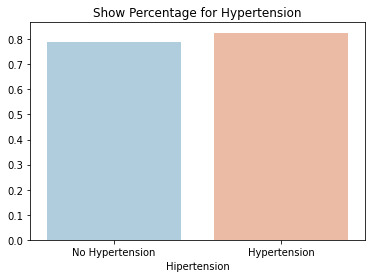

In [15]:
#Percentanges of Show between people who have hypertension and people who don't is considerably different, therefore I will keep this feature
train_h_ratio = train[train['No-show'] == 'No'].groupby(['Hipertension']).size()/train.groupby(['Hipertension']).size()
ax = sns.barplot(x=train_h_ratio.index, y=train_h_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Hypertension")
x_ticks_labels=['No Hypertension', 'Hypertension']
ax.set_xticklabels(x_ticks_labels)
print (train['Hipertension'].value_counts())
print (train_h_ratio)
plt.show()

0    56694
1    14042
Name: Hipertension, dtype: int64
Handcap
0    0.795819
1    0.809825
dtype: float64


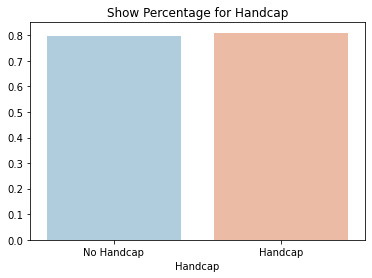

In [16]:
#Percentages of Show between people with a handicap and people who don't have one is very similar, therefore i will drop this feature
train_ha_ratio = train[train['No-show'] == 'No'].groupby(['Handcap']).size()/train.groupby(['Handcap']).size()
ax = sns.barplot(x=train_ha_ratio.index, y=train_ha_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Handcap")
x_ticks_labels=['No Handcap', 'Handcap']
ax.set_xticklabels(x_ticks_labels)
print (train['Hipertension'].value_counts())
print (train_ha_ratio)
plt.show()

0      2258
1      1444
52     1114
53     1071
38     1056
       ... 
98        5
115       4
100       3
102       2
99        1
Name: Age, Length: 103, dtype: int64
Age
0      0.820638
1      0.819945
2      0.836381
3      0.812046
4      0.772783
         ...   
98     0.800000
99     1.000000
100    1.000000
102    1.000000
115    0.500000
Length: 103, dtype: float64


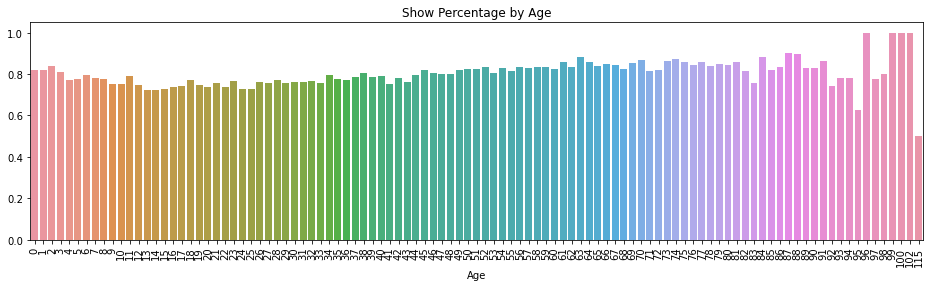

In [17]:
#Percentages of Show across all the ages is very similar and it also has a few outliers, therefore i will drop this feature
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
train_a_ratio = train[train['No-show'] == 'No'].groupby(['Age']).size()/train.groupby(['Age']).size()
ax = sns.barplot(x=train_a_ratio.index, y=train_a_ratio)
ax.set_title("Show Percentage by Age")

print (train['Age'].value_counts())
print (train_a_ratio)
plt.show()

JARDIM CAMBURI                 4942
MARIA ORTIZ                    3687
RESISTÊNCIA                    2862
JARDIM DA PENHA                2445
ITARARÉ                        2241
                               ... 
ILHA DO BOI                      24
AEROPORTO                         7
ILHA DO FRADE                     6
ILHAS OCEÂNICAS DE TRINDADE       1
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64
Neighbourhood
AEROPORTO              0.857143
ANDORINHAS             0.771307
ANTÔNIO HONÓRIO        0.804598
ARIOVALDO FAVALESSA    0.817204
BARRO VERMELHO         0.793233
                         ...   
SÃO JOSÉ               0.775244
SÃO PEDRO              0.785264
TABUAZEIRO             0.814045
UNIVERSITÁRIO          0.777778
VILA RUBIM             0.844444
Length: 81, dtype: float64


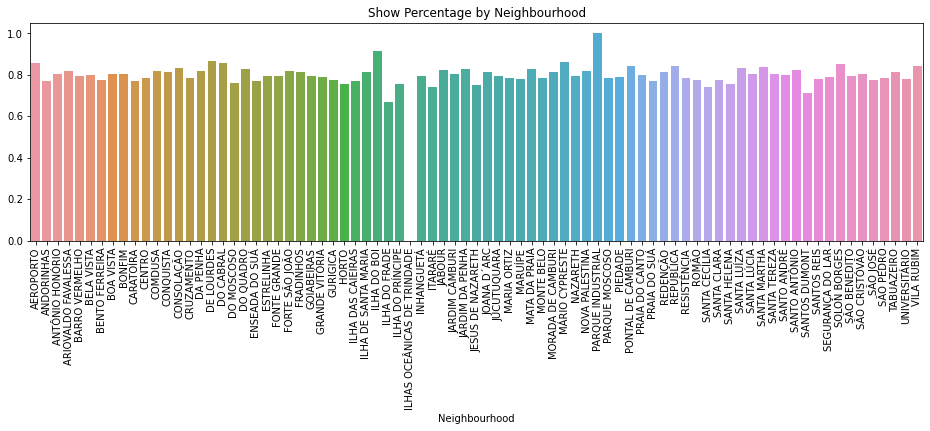

In [18]:
#Percentages of Show across Neighbourhoods is very similar and it also has a few outliers, therefore i will drop this feature
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
train_n_ratio = train[train['No-show'] == 'No'].groupby(['Neighbourhood']).size()/train.groupby(['Neighbourhood']).size()
ax = sns.barplot(x=train_n_ratio.index, y=train_n_ratio)
ax.set_title("Show Percentage by Neighbourhood")

print (train['Neighbourhood'].value_counts())
print (train_n_ratio)
plt.show()

I considered it useful to introduce a new feature which defines the days the patient waits from the moment he schedules the appointment to the day of the appointment itself. It would have been interesting to use the time of day of the appointment as a feature, but unfortunately the 'AppointmentDay' column of the dataset does not contain that information.

In [19]:
train['AppointmentDay']=train['AppointmentDay'].map(lambda d: parse(d))
test['AppointmentDay']=test['AppointmentDay'].map(lambda d: parse(d))
train['ScheduledDay']=train['ScheduledDay'].map(lambda d: parse(d))
test['ScheduledDay']=test['ScheduledDay'].map(lambda d: parse(d))
train['AppointmentDay']

0       2016-05-04 00:00:00+00:00
1       2016-06-01 00:00:00+00:00
2       2016-06-06 00:00:00+00:00
3       2016-06-07 00:00:00+00:00
4       2016-06-01 00:00:00+00:00
                   ...           
70731   2016-05-16 00:00:00+00:00
70732   2016-05-18 00:00:00+00:00
70733   2016-06-01 00:00:00+00:00
70734   2016-05-19 00:00:00+00:00
70735   2016-06-08 00:00:00+00:00
Name: AppointmentDay, Length: 70736, dtype: datetime64[ns, tzutc()]

In [20]:
DiffDaysTrain=[]
for d1,d2 in zip(train['AppointmentDay'],train['ScheduledDay']):
    DiffDaysTrain.append(abs(d1-d2).days)
DiffDaysTrain
DiffDaysTest=[]
for d1,d2 in zip(test['AppointmentDay'],test['ScheduledDay']):
    DiffDaysTest.append(abs(d1-d2).days)
DiffDaysTest

[31,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 21,
 0,
 17,
 12,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 63,
 2,
 6,
 0,
 0,
 5,
 65,
 0,
 0,
 0,
 0,
 3,
 5,
 0,
 27,
 5,
 0,
 0,
 34,
 0,
 10,
 0,
 20,
 0,
 3,
 30,
 27,
 1,
 31,
 0,
 27,
 6,
 0,
 7,
 17,
 0,
 3,
 0,
 39,
 0,
 0,
 1,
 3,
 0,
 5,
 1,
 65,
 1,
 8,
 4,
 7,
 0,
 3,
 0,
 1,
 9,
 2,
 2,
 0,
 4,
 0,
 4,
 28,
 24,
 12,
 0,
 0,
 0,
 0,
 24,
 0,
 38,
 0,
 20,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 0,
 28,
 0,
 0,
 3,
 5,
 1,
 30,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 33,
 0,
 72,
 0,
 12,
 12,
 0,
 0,
 42,
 29,
 2,
 0,
 16,
 13,
 0,
 29,
 0,
 0,
 0,
 11,
 3,
 33,
 1,
 0,
 60,
 0,
 15,
 9,
 13,
 12,
 67,
 8,
 3,
 10,
 17,
 0,
 0,
 0,
 4,
 0,
 0,
 25,
 0,
 0,
 18,
 0,
 1,
 30,
 13,
 13,
 9,
 12,
 0,
 36,
 2,
 8,
 0,
 5,
 5,
 1,
 60,
 0,
 33,
 0,
 0,
 0,
 16,
 0,
 0,
 6,
 16,
 1,
 0,
 7,
 5,
 27,
 3,
 0,
 8,
 13,
 0,
 25,
 0,
 10,
 12,
 2,
 21,
 2,
 13,
 0,
 1,
 62,
 4,
 4,
 1,
 4,
 43,
 37,
 0,
 0,
 10,
 0,
 0,
 0,
 40,
 6,
 6,
 6,
 0,
 0,
 29,
 33,
 1,
 3,
 0,
 0,
 0,


In [21]:
X_train['DiffDays']=DiffDaysTrain
X_train

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,DiffDays
0,93669256528597,F,2016-04-29T16:09:30Z,2016-05-04T00:00:00Z,67,GURIGICA,0,0,0,0,0,1,4
1,86583742322543,F,2016-06-01T09:24:48Z,2016-06-01T00:00:00Z,24,MARIA ORTIZ,0,0,0,0,0,0,0
2,386968219955593,M,2016-06-02T06:36:49Z,2016-06-06T00:00:00Z,66,ROMÃO,0,1,0,0,0,1,3
3,181532114569828,M,2016-06-03T15:29:57Z,2016-06-07T00:00:00Z,38,CARATOÍRA,0,0,1,0,0,1,3
4,656358778415,F,2016-05-30T16:16:36Z,2016-06-01T00:00:00Z,42,MARIA ORTIZ,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70731,518184171212245,M,2016-05-16T08:18:31Z,2016-05-16T00:00:00Z,1,JARDIM CAMBURI,0,0,0,0,0,0,0
70732,6617922261329,F,2016-05-03T17:09:43Z,2016-05-18T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,0,14
70733,551595432817182,M,2016-06-01T07:27:40Z,2016-06-01T00:00:00Z,13,MARIA ORTIZ,0,0,0,0,0,0,0
70734,862669993887852,M,2016-05-13T10:56:58Z,2016-05-19T00:00:00Z,42,RESISTÊNCIA,0,0,0,0,0,0,5


In [22]:
X_test['DiffDays']=DiffDaysTest
X_test

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,DiffDays
0,474353326277,F,2016-04-18T14:23:10Z,2016-05-20T00:00:00Z,36,ILHA DE SANTA MARIA,0,0,0,0,0,0,31
1,239584199629498,F,2016-05-19T14:55:46Z,2016-05-20T00:00:00Z,15,JABOUR,0,0,0,0,0,0,0
2,452116852376437,M,2016-06-03T14:09:56Z,2016-06-03T00:00:00Z,17,SANTA HELENA,0,0,0,0,0,0,0
3,91485643691841,F,2016-05-09T07:30:50Z,2016-05-10T00:00:00Z,20,DA PENHA,0,0,0,0,0,0,0
4,8759582319893,F,2016-05-24T12:10:04Z,2016-05-25T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17680,18825737946633,M,2016-05-02T11:21:36Z,2016-06-07T00:00:00Z,58,CENTRO,0,0,0,0,0,0,35
17681,67332384894251,M,2016-05-19T13:35:46Z,2016-06-06T00:00:00Z,83,MONTE BELO,0,0,0,0,0,0,17
17682,174622885754,M,2016-05-13T15:20:12Z,2016-05-13T00:00:00Z,20,CENTRO,0,0,0,0,0,0,0
17683,825376842781693,F,2016-06-01T07:22:00Z,2016-06-01T00:00:00Z,32,REDENÇÃO,0,0,0,0,0,0,0


In [23]:
#Feature Drop
X_train=X_train.drop(['Neighbourhood','Handcap','Age','Gender','Alcoholism'],axis=1)
X_test=X_test.drop(['Neighbourhood','Handcap','Age','Gender','Alcoholism'],axis=1)



In [24]:
#Feature to encode
le = preprocessing.LabelEncoder()
labels_to_encode=['ScheduledDay','AppointmentDay']

In [25]:
#Feature Encoding
for l in labels_to_encode:
    X_train[l]=le.fit_transform(X_train[l])
    X_test[l]=le.fit_transform(X_test[l])


X_train

,PatientId,ScheduledDay,AppointmentDay,Scholarship,Hipertension,Diabetes,SMS_received,DiffDays
0,93669256528597,17801,3,0,0,0,1,4
1,86583742322543,59994,21,0,0,0,0,0
2,386968219955593,60945,24,0,1,0,1,3
3,181532114569828,64036,25,0,0,1,1,3
4,656358778415,57303,21,0,0,0,0,1
...,...,...,...,...,...,...,...,...
70731,518184171212245,41434,12,0,0,0,0,0
70732,6617922261329,23070,14,0,0,0,0,14
70733,551595432817182,59475,21,0,0,0,0,0
70734,862669993887852,40079,15,0,0,0,0,5


In [26]:
#Target Encoding
y_train=le.fit_transform(y_train)

y_test=le.transform(y_test)
y_test

array([0, 0, 0, ..., 0, 0, 1])

In [27]:
#Model training and score
log = LogisticRegression()
log.fit(X_train, y_train)
print("\n Test Accuracy: ", (log.score(X_test, y_test) * 100), "%")


 Test Accuracy:  80.44105173876166 %
